<a href="https://colab.research.google.com/github/jenelaineDC/Natural-Language-Processing/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### SENTIMENT ANALYSIS

Goal:
- Use Vectorization Strategy such as CountVectorizer, TFIDF, or other options like Tokenization, Lemmatization
- Implement a Logistic Regression Classsifier and experiment with other type models.
- Check for Class Imbalance
- Assess models performance.

### Set-up

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

# word cloud
from wordcloud import WordCloud

### EDA

#### Data Source

In [2]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")
csv_file = os.path.join(path, "Tweets.csv")

# Load the CSV into a DataFrame
tweets = pd.read_csv(csv_file)

# Preview the DataFrame
tweets.head()

Using Colab cache for faster access to the 'twitter-airline-sentiment' dataset.


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

#### Data Cleaning

In [4]:
df = tweets[['airline_sentiment', 'text']].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [5]:
df['target'] = df['airline_sentiment'].map({
    'positive' : 1,
    'negative' : 0,
    'neutral'  : 2}
)

In [6]:
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [7]:
# Check count per class
df.value_counts('airline_sentiment')

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


#### Feature Engineering

In [8]:
!pip install -q spacy
import spacy
nlp = spacy.load("en_core_web_sm")


In [9]:
# Number of characters
df['num_characters'] = df['text'].apply(len)


def count_tokens(text):
    doc = nlp(text)
    num_words = len([token.text for token in doc])
    num_sentences = len(list(doc.sents))
    return num_words, num_sentences

# Number of Words and Number of Sentences
df[['num_words', 'num_sentences']] = df['text'].apply(
    lambda x: pd.Series(count_tokens(x)))

df.head()


,airline_sentiment,text,target,num_characters,num_words,num_sentences
0,neutral,@VirginAmerica What @dhepburn said.,2,35,5,1
1,positive,@VirginAmerica plus you've added commercials t...,1,72,12,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2,71,15,2
3,negative,@VirginAmerica it's really aggressive to blast...,0,126,23,1
4,negative,@VirginAmerica and it's a really big bad thing...,0,55,11,1


#### Visualization

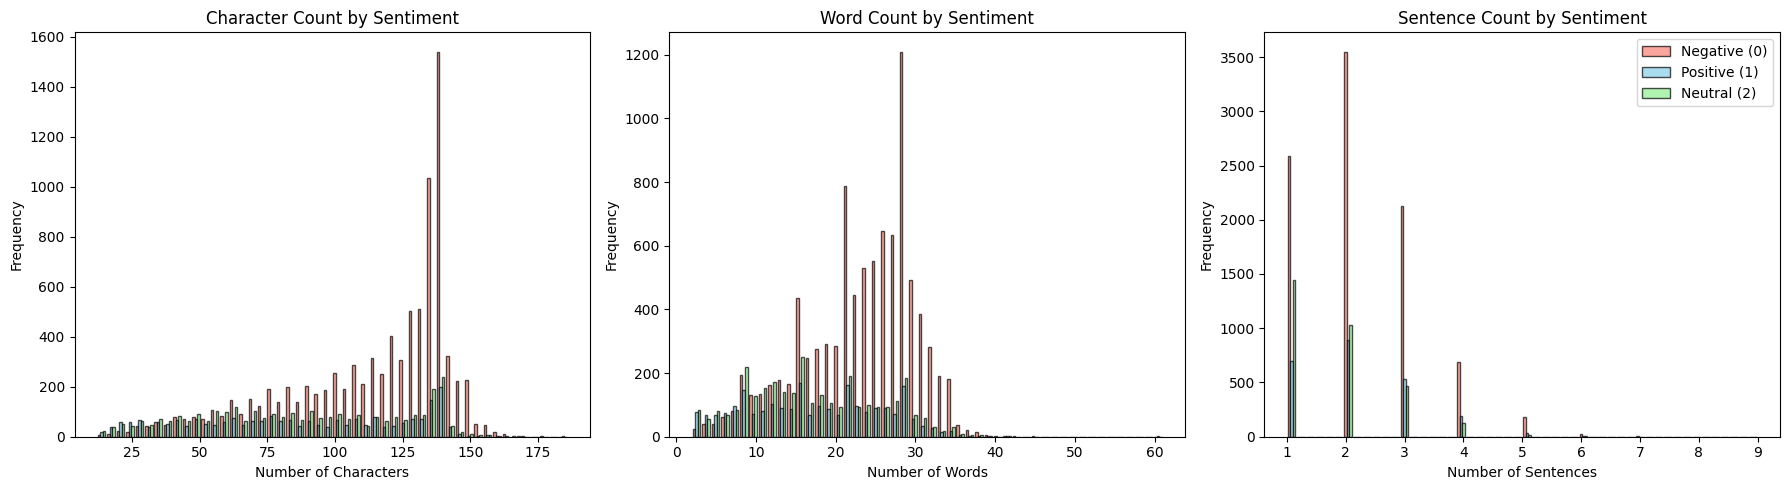

In [10]:
plt.figure(figsize=(18, 5))

# Define colors and labels for sentiment classes
colors = ['salmon', 'skyblue', 'lightgreen']
labels = ['Negative (0)', 'Positive (1)', 'Neutral (2)']

# Plot 1: Number of Characters
plt.subplot(1, 3, 1)
plt.hist(
    [
        df[df['target'] == 0]['num_characters'],
        df[df['target'] == 1]['num_characters'],
        df[df['target'] == 2]['num_characters']
    ],
    bins=50,
    label=labels,
    color=colors,
    edgecolor='black',
    alpha=0.7
)
plt.title('Character Count by Sentiment')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Plot 2: Number of Words
plt.subplot(1, 3, 2)
plt.hist(
    [
        df[df['target'] == 0]['num_words'],
        df[df['target'] == 1]['num_words'],
        df[df['target'] == 2]['num_words']
    ],
    bins=50,
    label=labels,
    color=colors,
    edgecolor='black',
    alpha=0.7
)
plt.title('Word Count by Sentiment')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Plot 3: Number of Sentences
plt.subplot(1, 3, 3)
plt.hist(
    [
        df[df['target'] == 0]['num_sentences'],
        df[df['target'] == 1]['num_sentences'],
        df[df['target'] == 2]['num_sentences']
    ],
    bins=50,
    label=labels,
    color=colors,
    edgecolor='black',
    alpha=0.7
)
plt.title('Sentence Count by Sentiment')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


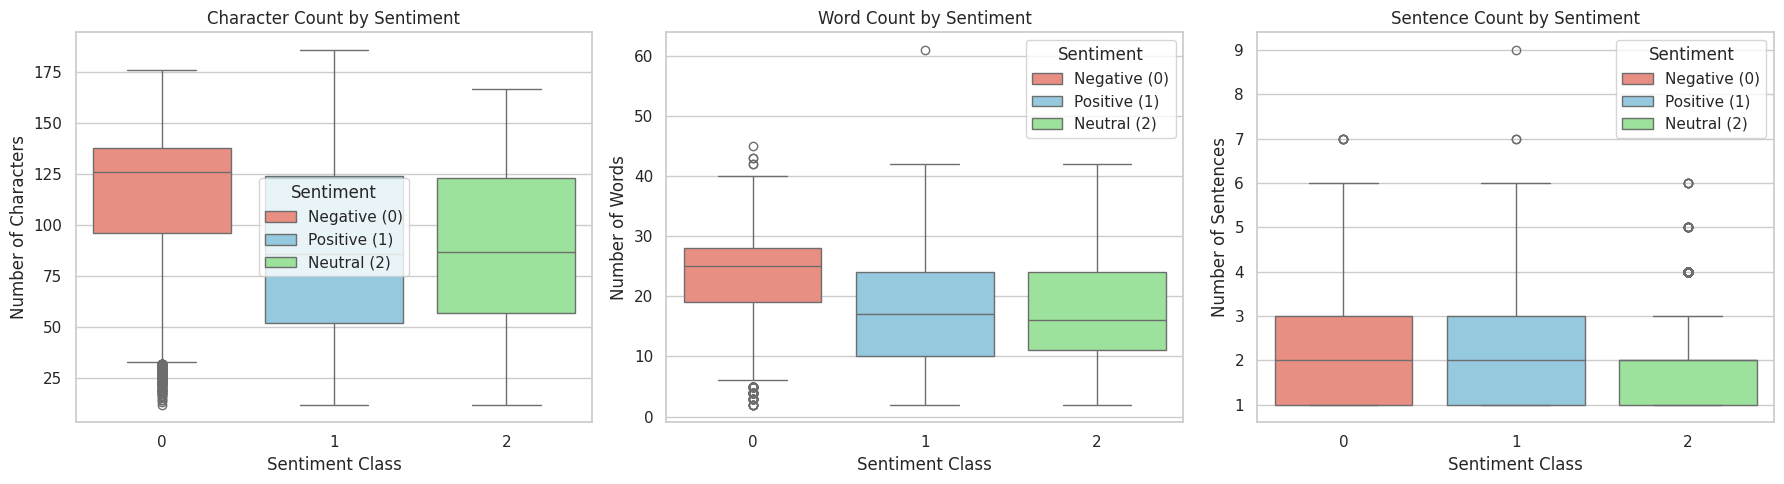

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

# Updated color palette and sentiment labels
colors = ['salmon', 'skyblue', 'lightgreen']
sentiment_labels = ['Negative (0)', 'Positive (1)', 'Neutral (2)']

# Plot 1: Characters
plt.subplot(1, 3, 1)
sns.boxplot(
    data=df,
    x='target',
    y='num_characters',
    hue='target',
    palette=colors
)
plt.title('Character Count by Sentiment')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Characters')
plt.legend(title='Sentiment', labels=sentiment_labels)

# Plot 2: Words
plt.subplot(1, 3, 2)
sns.boxplot(
    data=df,
    x='target',
    y='num_words',
    hue='target',
    palette=colors
)
plt.title('Word Count by Sentiment')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Words')
plt.legend(title='Sentiment', labels=sentiment_labels)

# Plot 3: Sentences
plt.subplot(1, 3, 3)
sns.boxplot(
    data=df,
    x='target',
    y='num_sentences',
    hue='target',
    palette=colors
)
plt.title('Sentence Count by Sentiment')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Sentences')
plt.legend(title='Sentiment', labels=sentiment_labels)

plt.tight_layout()
plt.show()


### Model Develoment

#### Train - Test Split

In [12]:
X = df[['text', 'num_characters', 'num_words', 'num_sentences']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
def evaluate_model_metrics(y_true, y_pred):
    """
    Returns a dictionary with accuracy, precision, recall, and F1-score
    """
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro')
    }


#### Vectorizer

In [14]:
def spacy_tokenizer(text):
    doc = nlp(text)
    tokens = []

    for token in doc:
        # Handle negations (e.g., "not good" -> "not_good")
        if token.dep_ == 'neg' and token.head.pos_ in ['ADJ', 'VERB']:
            tokens.append(f'not_{token.head.lemma_.lower()}')

        # Keep only meaningful tokens
        if token.is_stop or (token.is_punct and token.text not in ['!', '?']) or token.is_space:
            continue

        if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:
            tokens.append(token.lemma_.lower())

    # Add named entities (avoid duplicates)
    tokens = list(set(tokens + [ent.text.lower() for ent in doc.ents]))
    return tokens


In [15]:
vectorizers = {
    "CountVectorizer": CountVectorizer(stop_words='english'),
    "TF-IDF": TfidfVectorizer(stop_words='english'),
    "CountVectorizer_spacy": CountVectorizer(tokenizer=spacy_tokenizer),
    "TF-IDF_spacy": TfidfVectorizer(tokenizer=spacy_tokenizer)
}

#### Model Training

In [16]:
models = {
    "LogisticReg": LogisticRegression(max_iter=500),
    "MultinomialNB": MultinomialNB(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42, n_jobs=-1),
    "SVC": SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
}

In [17]:
# Store results
results = []

# Loop over vectorizers and models
for vec_name, vectorizer in vectorizers.items():

    # ColumnTransformer with MinMaxScaler to ensure non-negative features
    preprocessor = ColumnTransformer(
    transformers=[
        ('text', vectorizer, 'text'),
        ('num', MinMaxScaler(), ['num_characters', 'num_words', 'num_sentences'])
    ])


    for model_name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_test)

        # Evaluate
        metrics = evaluate_model_metrics(y_test, y_pred)

        # Save to results
        results.append({
            'Model': f"{model_name} + {vec_name}",
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1': metrics['f1']
        })



/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extr

#### Model Selection and Evaluation

##### Result Summary

In [18]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='F1', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Precision,Recall,F1
0,LogisticReg + CountVectorizer,0.789959,0.745347,0.703014,0.721182
1,LogisticReg + CountVectorizer_spacy,0.785519,0.735364,0.704859,0.718512
2,SVC + TF-IDF,0.760246,0.700706,0.727320,0.711311
3,SVC + TF-IDF_spacy,0.760246,0.696780,0.726797,0.708492
4,LogisticReg + TF-IDF,0.782445,0.751465,0.667183,0.698265
5,SVC + CountVectorizer,0.756148,0.695399,0.699372,0.696902
6,SVC + CountVectorizer_spacy,0.750000,0.688524,0.706403,0.695590
7,LogisticReg + TF-IDF_spacy,0.780055,0.746187,0.665868,0.695578
8,XGBClassifier + CountVectorizer_spacy,0.762978,0.720826,0.654795,0.680126
9,XGBClassifier + CountVectorizer,0.761612,0.717249,0.650051,0.675589


##### Confusion Matrix

In [19]:
# Lets recreate the best model based on the highest f1 score in order to produce a confusion matrix
preprocessor = ColumnTransformer(
        transformers=[
            ('text', CountVectorizer(stop_words='english'), 'text'),
            ('num', MinMaxScaler(), ['num_characters', 'num_words', 'num_sentences'])
        ]
    )

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  CountVectorizer(stop_words='english'),
                                                  'text'),
                                                 ('num', MinMaxScaler(),
                                                  ['num_characters',
                                                   'num_words',
                                                   'num_sentences'])])),
                ('classifier', LogisticRegression(max_iter=500))])

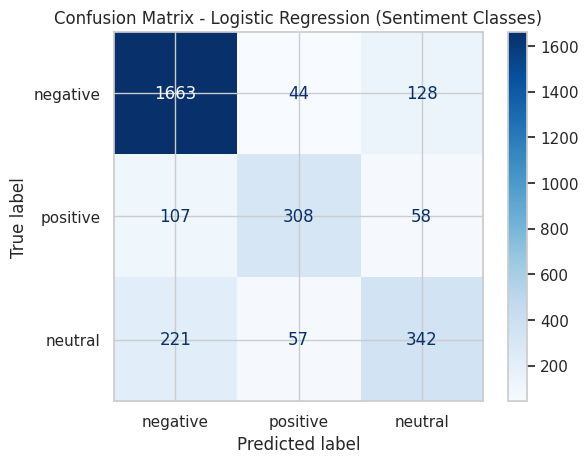


Classification Report:

              precision    recall  f1-score   support

    negative      0.835     0.906     0.869      1835
    positive      0.753     0.651     0.698       473
     neutral      0.648     0.552     0.596       620

    accuracy                          0.790      2928
   macro avg      0.745     0.703     0.721      2928
weighted avg      0.782     0.790     0.784      2928



In [20]:
# Predict on test data
y_pred = pipeline.predict(X_test)

# Define label mapping (ensure order matches your model classes)
label_mapping = {0: 'negative', 1: 'positive', 2: 'neutral'}
labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted(label_mapping.keys()))

# Display confusion matrix with sentiment labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression (Sentiment Classes)")
plt.show()

# Optional: print detailed metrics
print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=labels,
    digits=3
))


In [21]:
# Get the vectorizer and model from your pipeline
vectorizer = pipeline.named_steps['preprocessor'].named_transformers_['text']
scaler = pipeline.named_steps['preprocessor'].named_transformers_['num']
model = pipeline.named_steps['classifier']

# Combine feature names: text features + numeric feature names
text_features = vectorizer.get_feature_names_out()
num_features = ['num_characters', 'num_words', 'num_sentences']
feature_names = np.concatenate([text_features, num_features])

# Get coefficients
coef_df = pd.DataFrame(model.coef_, columns=feature_names)
coef_df['class'] = model.classes_

coef_df.head()


,00,000,000114,000419,0011,0016,00a,00am,00p,00pm,...,ztrdwv0n4l,zukes,zurich,zv2pt6trk9,zv6cfpohl5,zvfmxnuelj,zzps5ywve2,num_characters,num_words,num_sentences
0,0.302850,-0.012994,-0.235759,0.334029,-0.235846,0.040554,0.011506,0.068397,0.271096,0.106896,...,-0.178406,0.031823,0.331221,-0.124133,0.095304,0.157790,0.090642,2.676198,0.101074,-0.271258
1,-0.164455,-0.076821,-0.034339,-0.221917,-0.010926,-0.011098,-0.008515,-0.028946,-0.231373,-0.122230,...,-0.108895,-0.010942,-0.191416,-0.122785,-0.058432,-0.062244,-0.019357,-1.418548,-0.365489,1.373597
2,-0.138395,0.089816,0.270098,-0.112112,0.246771,-0.029455,-0.002991,-0.039451,-0.039723,0.015334,...,0.287302,-0.020882,-0.139805,0.246918,-0.036872,-0.095546,-0.071285,-1.257649,0.264414,-1.102339


##### Logistic Regression Coefficients

In [22]:
def plot_top_features_two_columns(class_index, n=10):
    class_name = label_mapping[class_index]
    coefs = coef_df.iloc[class_index][:-1]  # exclude class label column

    # Top positive features
    top_positive = coefs.sort_values(ascending=False).head(n)
    # Top negative features
    top_negative = coefs.sort_values(ascending=True).head(n)

    # Create figure with 2 columns, 1 row
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot positive features
    top_positive.plot(kind='barh', ax=axes[0], color='green')
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {n} Positive Features - '{class_name}' class", fontsize=14)
    axes[0].set_xlabel("Coefficient Strength")

    # Plot negative features
    top_negative.plot(kind='barh', ax=axes[1], color='red')
    axes[1].invert_yaxis()
    axes[1].set_title(f"Top {n} Negative Features - '{class_name}' class", fontsize=14)
    axes[1].set_xlabel("Coefficient Strength")

    plt.tight_layout()
    plt.show()


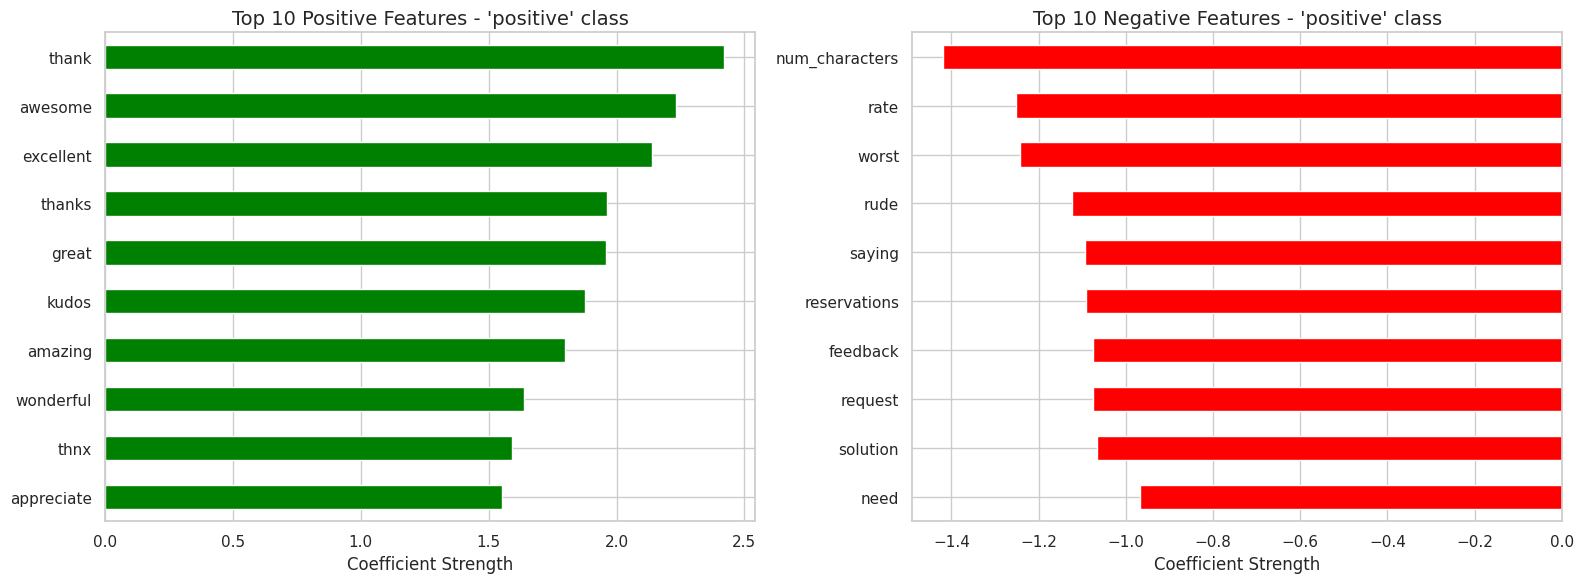

In [23]:
plot_top_features_two_columns(1)

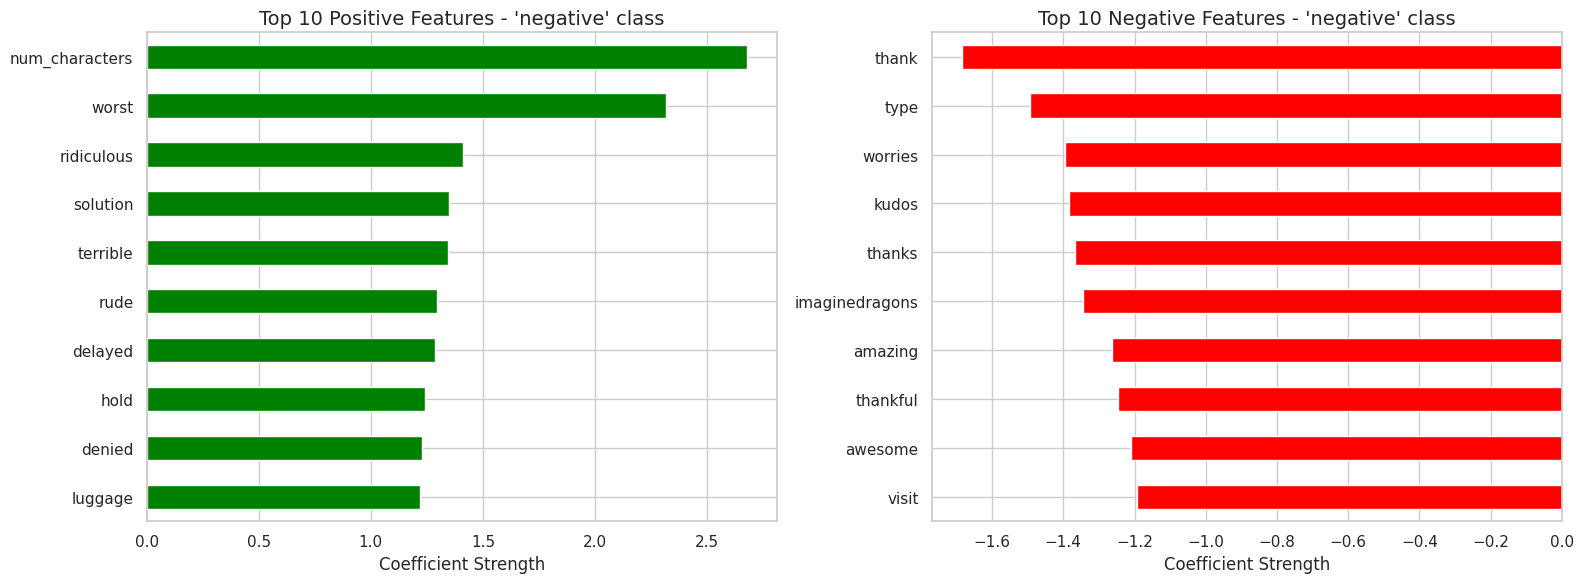

In [24]:
plot_top_features_two_columns(0)

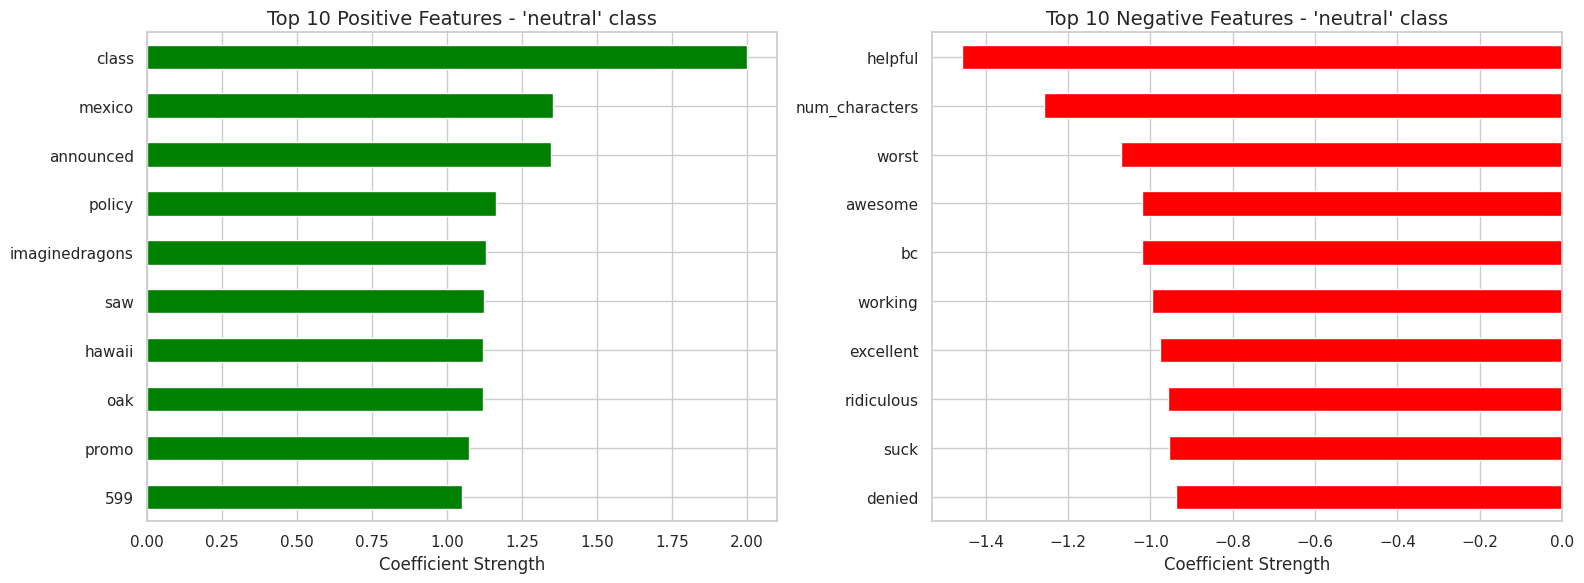

In [25]:
plot_top_features_two_columns(2)

##### Word Cloud

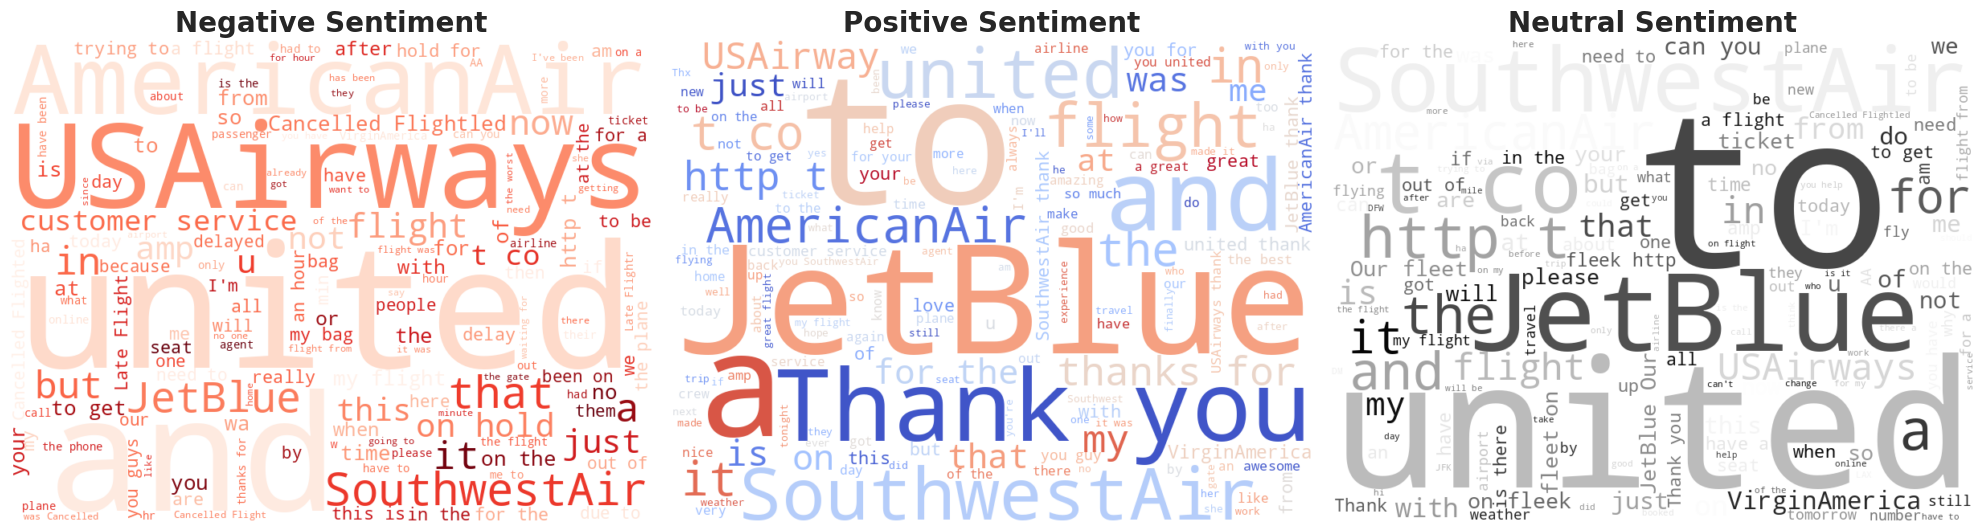

In [26]:
# Define mapping (numeric → text)
label_mapping = {0: 'negative', 1: 'positive', 2: 'neutral'}

# Set up the figure: 1 row × 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Define color scheme for each sentiment
color_map = {
    'positive': 'coolwarm',
    'negative': 'Reds',
    'neutral': 'Greys'
}

# Generate word clouds
for i, (label, name) in enumerate(label_mapping.items()):
    # Combine all text for this sentiment
    text_data = " ".join(df[df['target'] == label]['text'].astype(str))

    # Generate the word cloud
    wc = WordCloud(
        width=800,
        height=600,
        background_color='white',
        colormap=color_map[name],
        max_words=150,
        contour_color='black',
        contour_width=1,
        stopwords='english'
    ).generate(text_data)

    # Display each subplot
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"{name.capitalize()} Sentiment", fontsize=20, fontweight='bold')
    axes[i].axis('off')

# Adjust layout for neatness
plt.tight_layout()
plt.show()
